# ABOUT THE DATA
# Athabasca Oil Sands Data McMurray/Wabiskaw Oil Sands

In 1986, Alberta Geological Survey began a project to map the McMurray Formation and the overlying Wabiskaw Member of the Clearwater Formation in the Athabasca Oil Sands Area. The data that accompany this report are one of the most significant products of the project and will hopefully facilitate future development of the oil sands.


### Picks.xls
An Excel spreadsheet containing stratigraphic picks. 

SitID   A number used within AGS to identify wells.
HorID   Numbers used within the Athabasca Oil Sands Database to identify regionally correlatable stratigraphic picks. See Picks_dic for a description.
Pick    The depth of a pick in metres from the Kelly Bushing elevation.
Quality The degree of confidence placed on the correlation of a pick. The codes are:
-1  Missing pick. Pick is unknown or no data is available.
0   Pick was never deposited or has been eroded. High degree of confidence based on a complete data set and log suite.
1   Good pick. A high degree of confidence based on geophysical log correlation and core control.
2   Pick is highly interpretive but confirmed by surrounding wells.
3   Pick is uncertain due to poor or missing data and/or low degree of confidence in correlation.
4   Pick is based primarily on drillers logs or other reliable drilling information.


### Picks_dic.xls
An Excel spreadsheet used to describe the stratigraphic picks. This document is  used to describe the stratigraphic picks used in Picks.xls. 
The columns in the table are:
HorID   Numbers used within the Athabasca Oil Sands Database to identify regionally correlatable stratigraphic picks.
Description The description of the regionally correlatable stratigraphic pick.



### Wells.xls
An Excel spreadsheet used to identify wells. The columns in the table are:
SitID   A number used within AGS to identify wells.
UWI (AGS)   Unique well identifier used to identify wells based on the Alberta Township System of land designation. The items in the identifier are in the following order:
Township    3 characters
Meridian    1 character
Range   2 characters
Section 2 characters
Legal Sub-Division (LSD)    2 characters
Location exception  2 characters
Event sequence  1 character
UWI Unique well identifier used to identify wells based on the Alberta Township System of land designation. The items in the identifier are in the following order:
Location exception  2 characters
Legal Sub-Division (LSD)    2 characters
Section 2 characters
Township    3 characters
Range   2 characters
Meridian    1 character
Event sequence  1 character

## Lets first looks at the Picks data

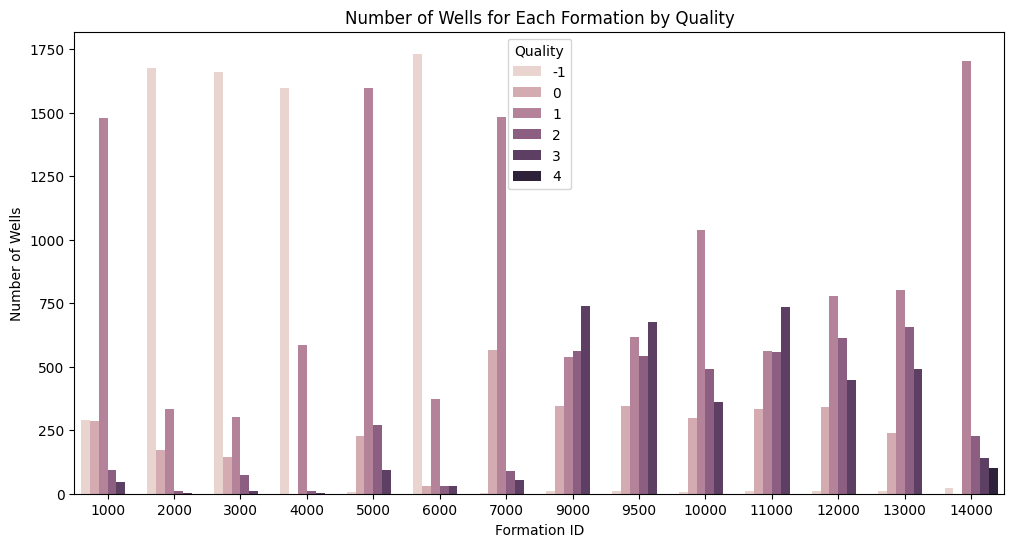

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

current_dir = os.getcwd()
# Define the file path
file_path = current_dir +"/Data/OilSandsDB/PICKS.xls"

# Read the Excel file into a DataFrame
picks_df= pd.read_excel(file_path)

# Display the first few rows of the DataFrame
picks_df.head()


# Step 1: Data Preparation
well_counts = picks_df.groupby(['HorID', 'Quality'])['SitID'].nunique().reset_index()

# Step 2: Visualization
plt.figure(figsize=(12, 6))

# Creating a bar chart
sns.barplot(x='HorID', y='SitID', hue='Quality', data=well_counts)

# Adding labels and title
plt.xlabel('Formation ID')
plt.ylabel('Number of Wells')
plt.title('Number of Wells for Each Formation by Quality')
plt.legend(title='Quality')

# Displaying the plot
plt.show()

In [2]:
unique_wells = picks_df['SitID'].nunique()
print(f"number of unique_wells: {unique_wells}")

print(picks_df)

number of unique_wells: 2193
        SitID  HorID      Pick  Quality
0      102496   1000       321        1
1      102496   2000                 -1
2      102496   3000                 -1
3      102496   4000                 -1
4      102496   5000       438        2
...       ...    ...       ...      ...
30697  184130  10000       149        3
30698  184130  11000       152        3
30699  184130  12000       152        2
30700  184130  13000       152        2
30701  184130  14000       202        1

[30702 rows x 4 columns]


We are going to create a model that will select a top for each formation. This means we need seperate data for each formation. It is important that the quality of the picks are good so that our model is not confused so we will select wells that have good quality (0 or 1) for each of the formations

In [3]:
# Assuming your DataFrame is named 'df'
# Step 1: Filter the DataFrame
filtered_df = picks_df[picks_df['Quality'].isin([0, 1, 2])]

# Step 2: Group by 'HorID' (formation ID) and count the unique Well IDs
formation_well_counts = filtered_df.groupby('HorID')['SitID'].nunique()

print(formation_well_counts)

HorID
1000     1858
2000      515
3000      519
4000      595
5000     2093
6000      431
7000     2138
9000     1447
9500     1507
10000    1826
11000    1448
12000    1733
13000    1693
14000    1928
Name: SitID, dtype: int64


In [4]:
wells_after_filter = filtered_df['SitID'].nunique()
print(f"number of unique_wells: {wells_after_filter}")

number of unique_wells: 2193


Below are functions to read las file which is the log data format and a way to convert UWI to the naminfg conventions of the file 

In [5]:
import lasio

def read_las_file_to_dataframe(file_path) ->pd.DataFrame:
    """
    Read a .las file into a Pandas DataFrame using lasio.
    
    Parameters:
    - file_path: str, path to the .las file
    
    Returns:
    - Pandas DataFrame containing the well log data from the .las file
    """
    las = lasio.read(file_path)
    return las.df()

def convert_las_to_uwi_format(las_name):
    no_extension = las_name.replace('.las', '')
    split_name = no_extension.split('-')
    formatted_name = split_name[0] + '/' + '-'.join(split_name[1:-1]) + '/' + split_name[-1]
    return formatted_name


### Filtering Wells to have necessary Logs
In the SPE paper they suggest having gamma-ray (GR), resistivity(ILD) and density logs (RHOB) to predict tops. Lets see what type of curves are present in the las files

In [6]:
# Define the file path
file_path = current_dir +"/Data/OilSandsDB/WELLS.xls"

# Read the Excel file into a DataFrame
wells_df= pd.read_excel(file_path)
print(wells_df.head())

    SitID      UWI (AGS)                  UWI
0  102496  0674010812000  00/12-08-067-01W4/0
1  102497  0674020807000  00/07-08-067-02W4/0
2  102498  0674021109000  00/09-11-067-02W4/0
3  102500  0674022910000  00/10-29-067-02W4/0
4  102501  0674023406000  00/06-34-067-02W4/0


First lets see what type of curves are present in the well log data

In [7]:
from collections import defaultdict

# Modify the format of the UWI values to match the .las file names
modified_uwis = [uwi.replace('/', '-') + '.las' for uwi in wells_df['UWI'].to_list()]

# Directory containing the .las files
logs_directory = current_dir+"/Data/OilSandsDB/Logs"

# Dictionary to store the count of logs that have each curve
curve_counts = defaultdict(int)

# Lists to keep track of included, excluded, and missing logs
missing_las = []

for uwi in modified_uwis:
    file_path = os.path.join(logs_directory, uwi)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Here you can use the appropriate .las reader to convert the .las file to a dataframe
        # I'll use a placeholder function called read_las_file_to_dataframe which you might need to replace
        df = read_las_file_to_dataframe(file_path)
        
        # Iterate over the columns (curves) in the dataframe and update their counts
        for curve in df.columns:
            curve_counts[curve] += 1
    else:
        missing_las.append(uwi)

# Printing the counts of logs that have each curve
for curve, count in curve_counts.items():
    print(f"Curve: {curve}, Count: {count}")

# Printing the counts of excluded and missing logs
print("Missing logs:", len(missing_las))

Curve: ILD, Count: 2154
Curve: DPHI, Count: 1915
Curve: NPHI, Count: 2006
Curve: GR, Count: 2169
Curve: CALI, Count: 783
Curve: DELT, Count: 98
Curve: LITH, Count: 1
Curve: RHOB, Count: 134
Curve: COND, Count: 3
Curve: PHID, Count: 10
Curve: PHID_ORIG, Count: 1
Curve: PHIN, Count: 6
Curve: DT, Count: 14
Curve: GR:1, Count: 1
Curve: DPHI:1, Count: 1
Curve: ILD:1, Count: 1
Curve: GR:2, Count: 1
Curve: DPHI:2, Count: 1
Curve: ILD:2, Count: 1
Curve: ILM, Count: 6
Curve: SFLU, Count: 6
Curve: SP, Count: 14
Curve: LLD, Count: 2
Curve: SN, Count: 1
Curve: IL, Count: 2
Curve: SFL, Count: 3
Curve: SNP, Count: 2
Curve: DENS, Count: 4
Curve: RESD, Count: 6
Curve: LLS, Count: 1
Curve: RT, Count: 1
Missing logs: 22


As we can see there is not to many density curves (RHOB) in this dataset. So instead we will replcae it with Density Porosity curve that is used to derive the density curve. We want to make sure they do not have any nan values

In [8]:
# List to store dataframes read from .las files
las_dataframes = []
excluded_las = []
missing_las = []
included_las = []
included_uwis =[]
for uwi in modified_uwis:
    file_path = os.path.join(logs_directory, uwi)
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Here you can use the appropriate .las reader to convert the .las file to a dataframe
        # I'll use a placeholder function called read_las_file_to_dataframe which you might need to replace
        df = read_las_file_to_dataframe(file_path)
        # Check if the dataframe contains all the required curves
        required_curves = ['GR', 'ILD', 'DPHI']
        if all(curve in df.columns for curve in required_curves):
            df = df[required_curves]
            # Check for NaN values in the required curves
            if not df[required_curves].isnull().values.any():
                df['uwi'] = convert_las_to_uwi_format(uwi)
                included_las.append(df)
                included_uwis.append(convert_las_to_uwi_format(uwi))
            else:
                excluded_las.append(convert_las_to_uwi_format(uwi))
        else:
            excluded_las.append(convert_las_to_uwi_format(uwi))
    else:
        missing_las.append(convert_las_to_uwi_format(uwi))

print(f"Number of well logs that have necessary curves and no NaN values: {len(included_las)}")
print(f"Number of excluded well logs: {len(excluded_las)}")
print(f"Number of missing well logs: {len(missing_las)}")

Number of well logs that have necessary curves and no NaN values: 1894
Number of excluded well logs: 277
Number of missing well logs: 22


In [9]:
mapping = wells_df.set_index('UWI')['SitID'].to_dict()  # Create a mapping of UWI to SitID

for las_df in included_las:
    las_df['SitID'] = las_df['uwi'].map(mapping)  # Replace UWI with SitID using the mapping
    las_df.drop(columns=['uwi'], inplace=True)  # Drop the UWI column

In [10]:
print(included_las[1].head())

             GR    ILD   DPHI   SitID
DEPT                                 
345.00  105.703  3.126  0.218  102497
345.25  101.298  3.184  0.231  102497
345.50  104.025  3.213  0.236  102497
345.75  106.147  3.267  0.236  102497
346.00  103.677  3.310  0.235  102497


In [11]:
# Assuming your original DataFrame is named 'df'
# Step 1: Create a mapping from 'UWI' to 'SitID'
uwi_to_sitid = dict(zip(wells_df['UWI'], wells_df['SitID']))

# Step 2: Convert the list of 'UWI' values to their corresponding 'SitID's
included_sitids = [uwi_to_sitid[uwi] for uwi in included_uwis if uwi in uwi_to_sitid]

# Step 3: Filter the 'filtered_df' to only include rows with the obtained 'SitID's
filtered_df = filtered_df[filtered_df['SitID'].isin(included_sitids)]
print(filtered_df['SitID'].nunique())


1894


In [12]:
# Step 2: Group by 'HorID' and collect the Well IDs
formation_wells = filtered_df.groupby('HorID')['SitID'].unique()

# Step 2: Group by 'HorID' (formation ID) and count the unique Well IDs
formation_well_counts = filtered_df.groupby('HorID')['SitID'].nunique()

print(formation_well_counts)

HorID
1000     1602
2000      379
3000      380
4000      503
5000     1806
6000      368
7000     1842
9000     1237
9500     1297
10000    1583
11000    1281
12000    1523
13000    1496
14000    1684
Name: SitID, dtype: int64


We do not need this many wells for each formation. In the research paper they trained their model on 150 well. So we are going to get a random sample of 200 wells from each formation. 150 will be used for training and 50 will be for testing.

In [13]:

from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'filtered_df' is your DataFrame after all the filtering you've done
formation_train_test_sets = {}

# Group by 'HorID' (formation ID)
for formation, group in filtered_df.groupby('HorID'):
    # Ensure that there are at least enough wells to sample 200 unique wells
    unique_wells = group['SitID'].unique()
    if len(unique_wells) >= 200:
        # Sample 200 unique wells
        selected_wells = np.random.choice(unique_wells, size=200, replace=False)
        
        # Filter the group to include only the selected wells
        selected_group = group[group['SitID'].isin(selected_wells)]
        
        # Perform the train-test split
        train_df, test_df = train_test_split(selected_group, test_size=0.25, random_state=42)
        
        # Store the training and testing sets in a dictionary
        formation_train_test_sets[formation] = {'train': train_df, 'test': test_df}
    else:
        print(f"Not enough unique wells for formation {formation} to create the desired split.")


Now we have a list of wells we want for our train and test groups for each formation. Next we need to apply the depths for the specific formation of these test and train samples to the las dataframes. 

In [14]:
# Create a dictionary of (SitID, HorID) to a list of pick depths
pick_dict = picks_df.groupby(['SitID', 'HorID'])['Pick'].apply(list).to_dict()

def is_pick_nearby(depth, next_depth, pick_depths, formation):
    """
    Check if there is a pick depth that falls between the current depth and the next depth.
    Only consider picks associated with the current formation.
    """ 
    for pick_depth in pick_depths:
        try:
            # Convert pick_depth to float
            pick_depth = float(pick_depth)
            if depth <= pick_depth < next_depth:
                return 1
        except ValueError:
            # If conversion fails, skip this pick_depth
            continue
    return 0

def apply_picks_for_well(df, formation):
    # Adjust the function to also receive the current formation
    depths= df.index.tolist()
    sitid = df['SitID'].iloc[0]
    picks_for_this_well = pick_dict.get((sitid, formation), [])
    picks_column =[]
    for i in range(len(depths)-1):
        try:
            current_depth = float(depths[i])
            next_depth = float(depths[i+1])
            # Pass the current formation to the function
            picks_column.append(is_pick_nearby(current_depth, next_depth, picks_for_this_well, formation))
        except ValueError:
            # If conversion fails, treat as no pick nearby
            picks_column.append(0)
    
    picks_column.append(0)  # for the last depth value
    df['Pick'] = picks_column
    df['Formation'] = formation
    return df

In [15]:
# Create a mapping from 'SitID' to the corresponding dataframe in 'included_las'
las_mapping = {df['SitID'].iloc[0]: df for df in included_las}


current_dir = os.getcwd()
# Directory to save the CSV files
output_directory = current_dir+'/Data/Formation_DATA'

def apply_picks_to_formation_wells(formation_train_test_sets, formation, las_mapping, output_directory):
    for set_type in ['train', 'test']:
        # Get the SitIDs for the current set
        sitids = formation_train_test_sets[formation][set_type]['SitID'].unique()
        
        for sitid in sitids:
            # Retrieve the corresponding dataframe
            las_df = las_mapping.get(sitid)
            if las_df is not None:
                # Create a copy of the dataframe to apply the picks
                las_df_copy = las_df.copy()
                # Apply the picks to the copied dataframe
                apply_picks_for_well(las_df_copy, formation)
                
                # Create directories if they don't exist
                directory_path = os.path.join(output_directory, str(formation), set_type)
                os.makedirs(directory_path, exist_ok=True)
                # Optionally, save the altered dataframe as a CSV file
                csv_filename = output_directory+ f"/{str(formation)}/{set_type}/{str(sitid)}.csv"
                csv_filepath = os.path.join(output_directory, csv_filename)
                las_df_copy.to_csv(csv_filepath, index=True)
                
                # Store the file path in the formation_train_test_sets
                formation_train_test_sets[formation][set_type].loc[formation_train_test_sets[formation][set_type]['SitID'] == sitid, 'DataFramePath'] = csv_filepath

# Now apply the picks to the wells in each formation's training and testing sets
for formation in formation_train_test_sets:
    apply_picks_to_formation_wells(formation_train_test_sets, formation, las_mapping, output_directory)